Jednowymiarowy ruch pieszego opisany jest równaniem:
$$ m_i\frac{\operatorname{d}\!v_i}{\operatorname{d}\!t} = F_i $$
Gdzie 
$$ F_i = F_{i}^{drv} + F_{i}^{rep} $$
Pierwszy składnik związany jest z zamierzoną prędkością pieszego, do której dąży w swoim ruchu i wyraża się wzorem:
$$ F_{i}^{drv} = m_i \frac{v_i^0 - v_i}{\tau_i} $$
gdzie $\tau$ jest parametrem przyspieszenia. Wybieramy parametr ten stały dla wszystkich pieszych i równy $\tau = 0.61$ (zgodnie z [1] strona 4)

Drugi składnik $F_i^{rep}$ związany jest z kolei z odległością pomiędzy poszczególnymi pieszymi. W pierwszym przybliżeniu czynnik ten pomijamy.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


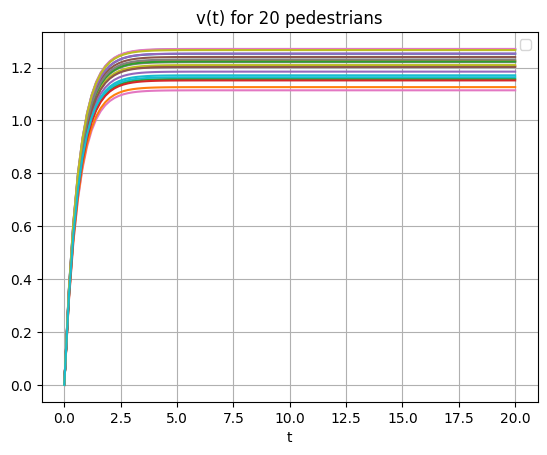

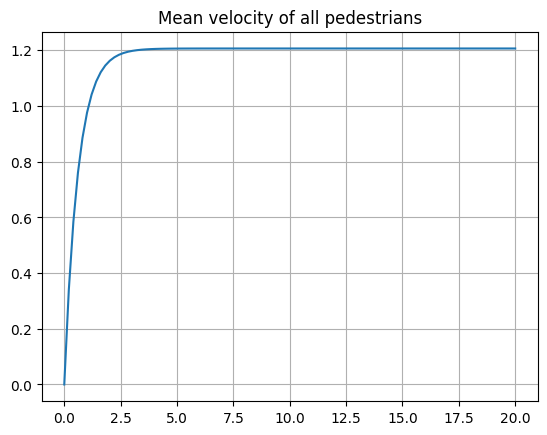

In [70]:
## rozwiązanie z użyciem wbudownych funkcji - prędkość
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#simplified equation od pedestrian 
def pedestrian_vel(v, t, v0, tau):
    dvdt = (v0 - v)/tau
    return dvdt

v0s = np.random.normal(1.24, 0.05, 20) #zgodnie z [1] strona 4
tau = 0.61

#initial conditions
v_0 = 0  
t = np.linspace(0,20,100)
time_step = 20/100


sol = [odeint(pedestrian_vel, v_0, t, args = (v0,tau)) for v0 in v0s]

for i in range(20):
    plt.plot(t, sol[i])
plt.title("v(t) for 20 pedestrians")
plt.xlabel('t')
plt.legend()
plt.grid()
plt.show()

mean_vel = np.mean(sol, axis =0)
plt.plot(t, mean_vel)
plt.title("Mean velocity of all pedestrians")
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.         0.35665799 0.61270462 0.79661348 0.9286953  1.02333644
 1.09160733 1.14044208 1.17536394 1.20075219 1.21890361 1.23171129
 1.24102104 1.24789572 1.25274105 1.25605247 1.25842771 1.26032614
 1.26172398 1.26265144 1.26320822 1.26356326 1.26392862 1.26427677
 1.26453634 1.26468392 1.26472536 1.26469581 1.26465973 1.26470611
 1.26481962 1.26493608 1.26502072 1.26505289 1.26502614 1.26494815
 1.26484075 1.26473995 1.2646959  1.26477907 1.26501892 1.26531365
 1.26557319 1.26573254 1.26575183 1.26561624 1.26533605 1.26494663
 1.26450842 1.26410698 1.26385292 1.26388197 1.26423799 1.26465728
 1.26500101 1.26518608 1.26517856 1.26499367 1.2646958  1.26439851
 1.26426451 1.26443874 1.26470112 1.26493191 1.2650724  1.26509458
 1.26500117 1.26482562 1.26463208 1.26451544 1.26459257 1.26481902
 1.2650722  1.26527086 1.26536224 1.26532209 1.26515463 1.26489259
 1.26459718 1.26435813 1.26429363 1.26453322 1.26500241 1.26550179
 1.26588028 1.266039   1.26593124 1.26556248 1.26499042 1.2643

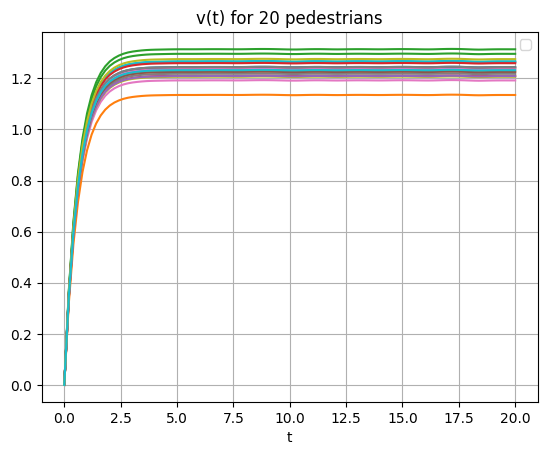

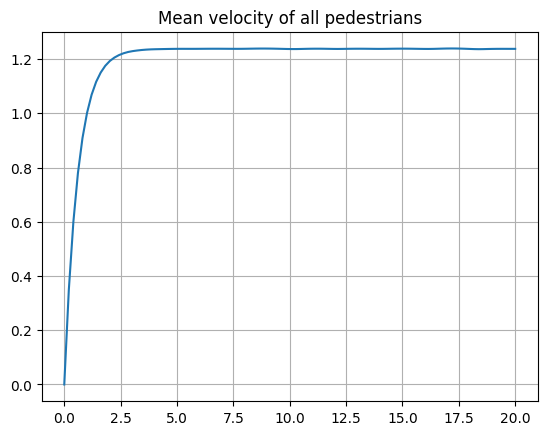

In [107]:
## rozwiązanie z użyciem wbudownych funkcji - prędkość
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#simplified equation od pedestrian 
def pedestrian_vel(t,v, v0, tau):
    dvdt = (v0 - v)/tau
    return dvdt

v0s = np.random.normal(1.24, 0.05, 20) #zgodnie z [1] strona 4
tau = 0.61

#initial conditions
v_0 = 0  
t = np.linspace(0,20,100)
time_step = 20/100

#using explicit Runge-Kutta method of order 5(4)
sol = [ (solve_ivp(pedestrian_vel, (0.0,20.0),[0], method = 'RK45', args = (v0,tau), t_eval = t)).y[0] for v0 in v0s]
print(sol[0])
for i in range(20):
    plt.plot(t, sol[i])
plt.title("v(t) for 20 pedestrians")
plt.xlabel('t')
plt.legend()
plt.grid()
plt.show()

mean_vel = np.mean(sol, axis =0)
plt.plot(t, mean_vel)
plt.title("Mean velocity of all pedestrians")
plt.grid()
plt.show()

In [71]:
#położenie
#przyjmujemy przestrzeń o długości 20m

# x = x0 + v_0*t + a*t^2/2
# a = (v_current - v_prev)/timestep

def position(v_0, x0, v_current, v_previous, timestep, t):
    a = (v_current-v_previous)/timestep
    result = x0 + v_0*t + (a*t*t)/2
    return result

x0s = np.random.normal(10, 5, 20)
print((sol[0][j-1][0] - sol[0][j][0]) for j in range(1,100))
print([position(0, x0s[0], sol[0][j][0], sol[0][j-1][0], time_step, t[j]) for j in range(1,100)])

positions_0 = [position(0, x0s[i], sol[0][j][0], sol[0][j-1][0], time_step, t[j]) for i in range(20) for j in range(1,100)]



<generator object <genexpr> at 0x000002891C2E5FF0>
[15.479407042773651, 15.546837529614915, 15.610525661719885, 15.656751143685211, 15.682779417573276, 15.690925421419077, 15.685326323784654, 15.670300874731671, 15.649609915817818, 15.626206912899585, 15.602234708583907, 15.579134105116076, 15.557787529319153, 15.538660360873424, 15.521923796879738, 15.507553339250446, 15.495403791721841, 15.485263582701682, 15.476892671421751, 15.470046933616185, 15.464494126641075, 15.460022480814613, 15.456444293143008, 15.453597306905706, 15.451343707694488, 15.449567740783769, 15.448174342072049, 15.447085409817968, 15.44623701306041, 15.445578277135642, 15.445068376519036, 15.444674935892422, 15.444371749592287, 15.44413883161073, 15.443960448307996, 15.443823808742426, 15.44371951850102, 15.443640564693052, 15.443579997353721, 15.4435337981815, 15.443498771565823, 15.44347269994188, 15.443452861975821, 15.443437681071781, 15.443426301681345, 15.443417924683365, 15.443411924241126, 15.44340762982

Bibliografia:

[1] Basics of modelling the pedestrian flow - Armin Seyfried, Bernhard Steffen, Thomas Lippert